# Global Climate Data Analysis
**Analyzing 30+ years of climate data to explore relationships between greenhouse gases, temperature, and sea level**

**Project Team:** Clay Grant, Austin Hill, Luke Nachnani, Abrihim Bolisetty  
**Course:** STOR 320 - Methods and Models of Data Science  
**University:** University of North Carolina at Chapel Hill

## Project Overview
This analysis investigates correlations between global land temperatures, sea levels, and greenhouse gas concentrations using statistical modeling and time-series analysis on data from 1992-2013.

## Data Cleaning and Preparation

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import statsmodels.api as sm

In [6]:
%pip install --upgrade kagglehub

Note: you may need to restart the kernel to use updated packages.


In [7]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/unraveling-global-climate-change-through-tempera")

print("Path to dataset files:", path)

Path to dataset files: /Users/lukenachnani/.cache/kagglehub/datasets/thedevastator/unraveling-global-climate-change-through-tempera/versions/2


In [8]:
csvs = list(Path(path).rglob('*.csv'))
for p in csvs:
    print(p.name)
    

GlobalLandTemperaturesByCountry.csv
GlobalLandTemperaturesByMajorCity.csv
GlobalLandTemperaturesByState.csv
GlobalTemperatures.csv


In [9]:
land_df = pd.read_csv(csvs[0])

In [10]:
## column names check (1 point) 
land_df.columns

Index(['index', 'dt', 'AverageTemperature', 'AverageTemperatureUncertainty',
       'Country'],
      dtype='object')

In [11]:
## missing data check (1 point)
land_df.isnull().sum()

index                                0
dt                                   0
AverageTemperature               32651
AverageTemperatureUncertainty    31912
Country                              0
dtype: int64

In [12]:
land_df = land_df.dropna(subset=["AverageTemperature"])

In [13]:
land_df["year"] = pd.to_datetime(land_df["dt"]).dt.year
land_df = land_df[["year", "AverageTemperature", "Country"]]
land_df.head()

,year,AverageTemperature,Country
0,1743,4.384,Åland
5,1744,1.530,Åland
6,1744,6.702,Åland
7,1744,11.609,Åland
8,1744,15.342,Åland


In [14]:
temps_global = land_df.groupby('year')['AverageTemperature'].mean().reset_index().rename(columns = {'AverageTemperature' : 'AverageTemperature: Celsius'})
temps_global

,year,AverageTemperature: Celsius
0,1743,5.184140
1,1744,9.837898
2,1745,1.387125
3,1750,9.129353
4,1751,9.167388
...,...,...
262,2009,19.546385
263,2010,19.629806
264,2011,19.456040
265,2012,19.468744


In [15]:
url = "https://sealevel.colorado.edu/files/2025_rel1/gmsl_2025rel1_seasons_rmvd.txt"
gmsl = pd.read_csv(url, comment="#", sep='\s+', header=None, names=["decimal_year", "gmsl_mm"]).dropna()
gmsl

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/np/tz99jl4x67sbx0jd37g2kyr00000gn/T/ipykernel_58767/3062629373.py:2: SyntaxWarning: invalid escape sequence '\s'
  gmsl = pd.read_csv(url, comment="#", sep='\s+', header=None, names=["decimal_year", "gmsl_mm"]).dropna()


,decimal_year,gmsl_mm
0,1992.959498,-17.013
1,1992.984581,-19.917
2,1993.010369,-21.738
3,1993.038722,-21.662
4,1993.062159,-21.288
...,...,...
1150,2025.072997,91.731
1151,2025.100165,92.021
1152,2025.127329,96.764
1153,2025.154495,95.285


In [16]:
## Outlier check (1 point)
temps_Q1 = temps_global['AverageTemperature: Celsius'].quantile(0.25)
temps_Q3 = temps_global['AverageTemperature: Celsius'].quantile(0.75)
temps_IQR = temps_Q3 - temps_Q1
temps_lower = temps_Q1 - 1.5 * temps_IQR
temps_upper = temps_Q3 + 1.5 * temps_IQR
temps_outliers = temps_global[(temps_global['AverageTemperature: Celsius'] < temps_lower) | (temps_global['AverageTemperature: Celsius'] > temps_upper)]
print(f'Outliers outside of IQR: {temps_outliers}')

Outliers outside of IQR: Empty DataFrame
Columns: [year, AverageTemperature: Celsius]
Index: []


In [17]:
## Outlier check (1 point)
gmsl_Q1 = gmsl['gmsl_mm'].quantile(0.25)
gmsl_Q3 = gmsl['gmsl_mm'].quantile(0.75)
gmsl_IQR = gmsl_Q3 - gmsl_Q1
gmsl_lower = gmsl_Q1 - 1.5 * gmsl_IQR
gmsl_upper = gmsl_Q3 + 1.5 * gmsl_IQR
gmsl_outliers = gmsl[(gmsl['gmsl_mm'] < gmsl_lower) | (gmsl['gmsl_mm'] > gmsl_upper)]
print(f'Outliers outside of IQR: {gmsl_outliers}')

Outliers outside of IQR: Empty DataFrame
Columns: [decimal_year, gmsl_mm]
Index: []


In [19]:
## data merging (1 point) and data transformation, normalization, and cleaning (1 point)

In [20]:
gmsl.copy()
gmsl['year'] = gmsl['decimal_year'].astype(int)
gmsl_year = gmsl.groupby('year', as_index = False)['gmsl_mm'].mean()
gmsl_year

,year,gmsl_mm
0,1992,-18.465000
1,1993,-16.455441
2,1994,-11.599324
3,1995,-6.317871
4,1996,-2.913265
5,1997,1.799818
6,1998,0.859818
7,1999,0.045455
8,2000,4.642382
9,2001,10.710306


In [21]:
combined = pd.merge(temps_global, gmsl_year,on = 'year', how = 'inner')
combined

,year,AverageTemperature: Celsius,gmsl_mm
0,1992,18.972007,-18.465000
1,1993,18.930800,-16.455441
2,1994,19.251702,-11.599324
3,1995,19.267070,-6.317871
4,1996,18.958375,-2.913265
5,1997,19.250351,1.799818
6,1998,19.596783,0.859818
7,1999,19.392100,0.045455
8,2000,19.349202,4.642382
9,2001,19.425303,10.710306


In [22]:
## Exploratory data visualization (1 point)

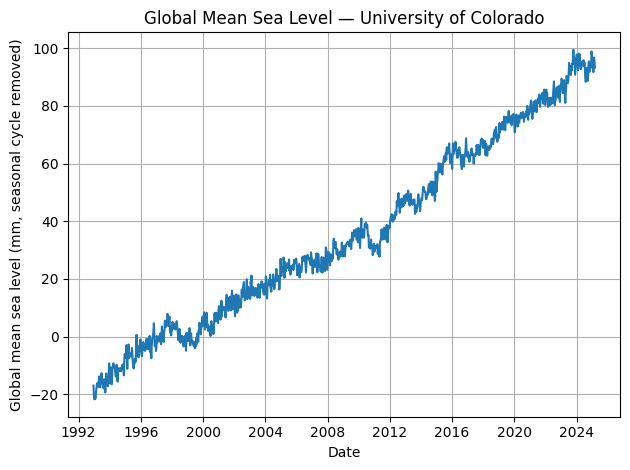

In [23]:
year = np.floor(gmsl["decimal_year"]).astype(int)
frac = gmsl["decimal_year"] - year
dates = pd.to_datetime(year, format="%Y") + pd.to_timedelta(frac * 365.2425, unit="D")

plt.figure()
plt.plot(dates, gmsl["gmsl_mm"])
plt.xlabel("Date")
plt.ylabel("Global mean sea level (mm, seasonal cycle removed)")
plt.title("Global Mean Sea Level — University of Colorado")
plt.grid(True)
plt.tight_layout()

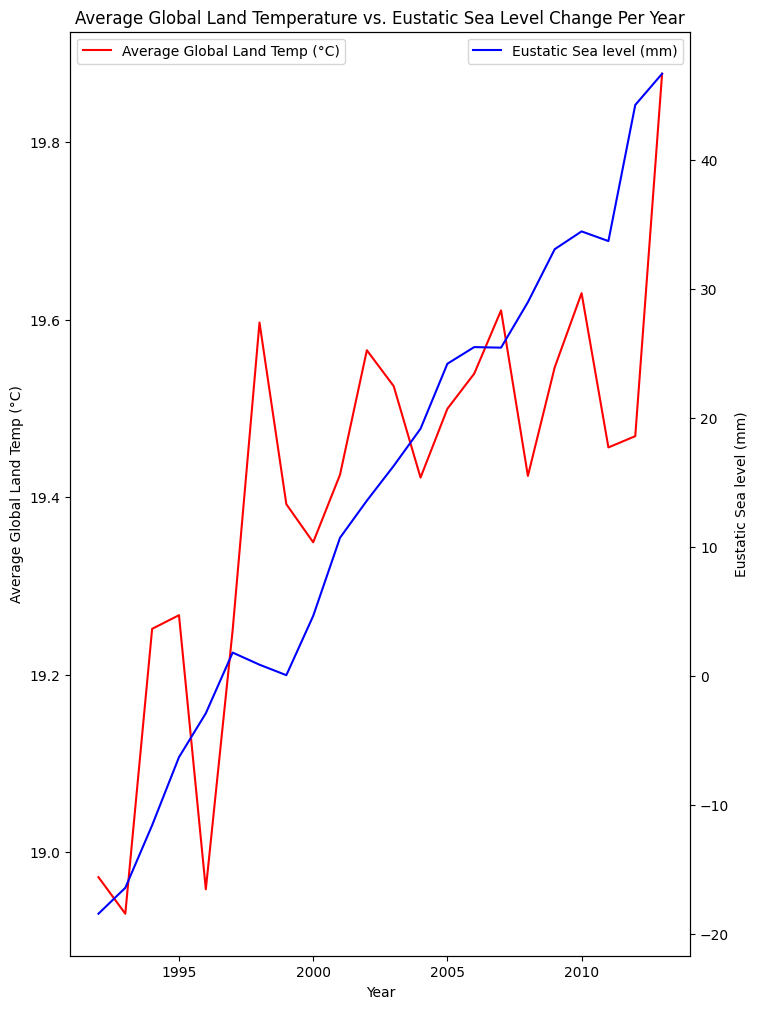

In [24]:
fig, ax1 = plt.subplots(figsize = (8,12))
sns.lineplot(data = combined, x = 'year', y = 'AverageTemperature: Celsius', ax = ax1, color = 'red', label = 'Average Global Land Temp (°C)')
ax2 = ax1.twinx()
sns.lineplot(data = combined, x = 'year', y = 'gmsl_mm', ax = ax2, color = 'blue', label = 'Eustatic Sea level (mm)')
ax1.legend(loc = 'upper left')
ax1.set_ylabel('Average Global Land Temp (°C)', loc = 'center')
ax2.set_ylabel('Eustatic Sea level (mm)')
ax1.set_xlabel('Year')
plt.title('Average Global Land Temperature vs. Eustatic Sea Level Change Per Year')
plt.show()

In [25]:
combined[['AverageTemperature: Celsius', 'gmsl_mm']].corr()

,AverageTemperature: Celsius,gmsl_mm
AverageTemperature: Celsius,1.000000,0.790972
gmsl_mm,0.790972,1.000000


In [26]:
combined['land_smooth'] = combined['AverageTemperature: Celsius'].rolling(window = 5).mean()
combined['sea_level_smooth'] = combined['gmsl_mm'].rolling(window = 5).mean()

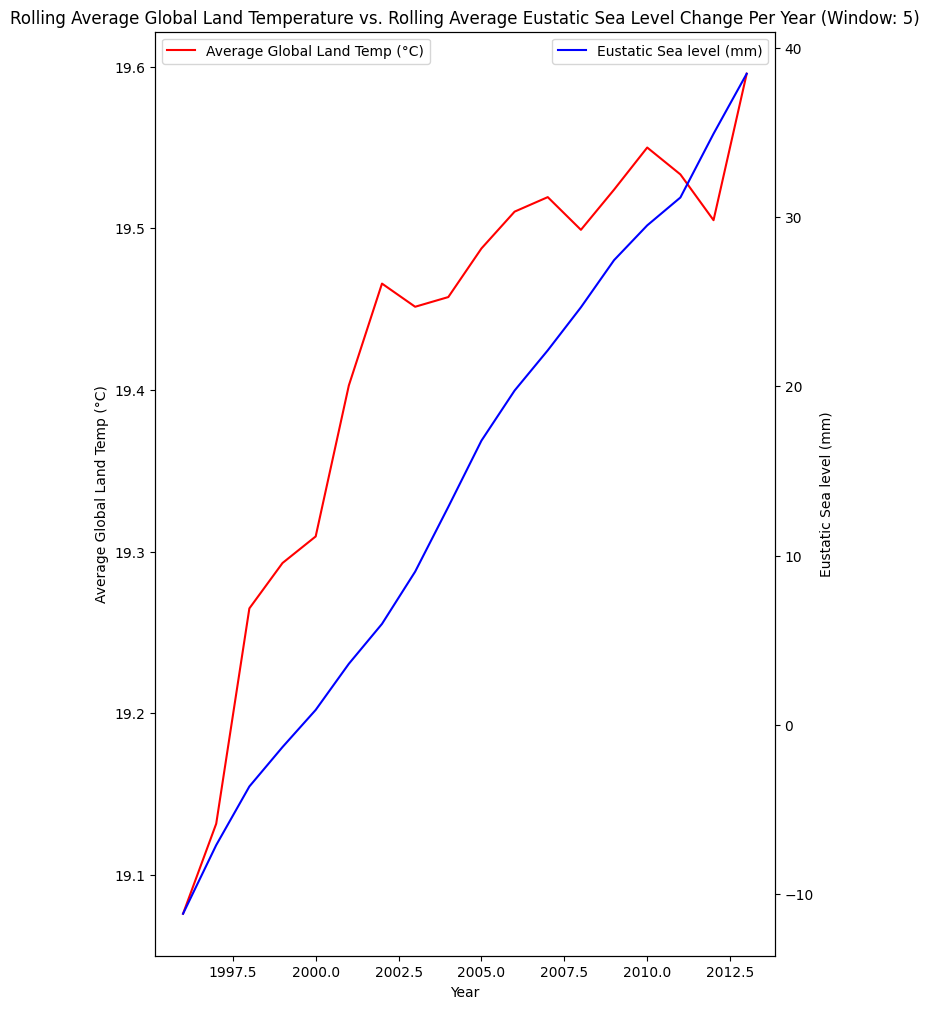

In [27]:
fig, ax1 = plt.subplots(figsize = (8,12))
sns.lineplot(data = combined, x = 'year', y = 'land_smooth', ax = ax1, color = 'red', label = 'Average Global Land Temp (°C)')
ax2 = ax1.twinx()
sns.lineplot(data = combined, x = 'year', y = 'sea_level_smooth', ax = ax2, color = 'blue', label = 'Eustatic Sea level (mm)')
ax1.legend(loc = 'upper left')
ax1.set_ylabel('Average Global Land Temp (°C)', loc = 'center')
ax2.set_ylabel('Eustatic Sea level (mm)')
ax1.set_xlabel('Year')
plt.title('Rolling Average Global Land Temperature vs. Rolling Average Eustatic Sea Level Change Per Year (Window: 5)')
plt.show()

In [28]:
X = combined['AverageTemperature: Celsius']
y = combined['gmsl_mm']
X = sm.add_constant(X)
ols = sm.OLS(y, X).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                gmsl_mm   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     33.42
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           1.17e-05
Time:                        10:18:54   Log-Likelihood:                -84.900
No. Observations:                  22   AIC:                             173.8
Df Residuals:                      20   BIC:                             176.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

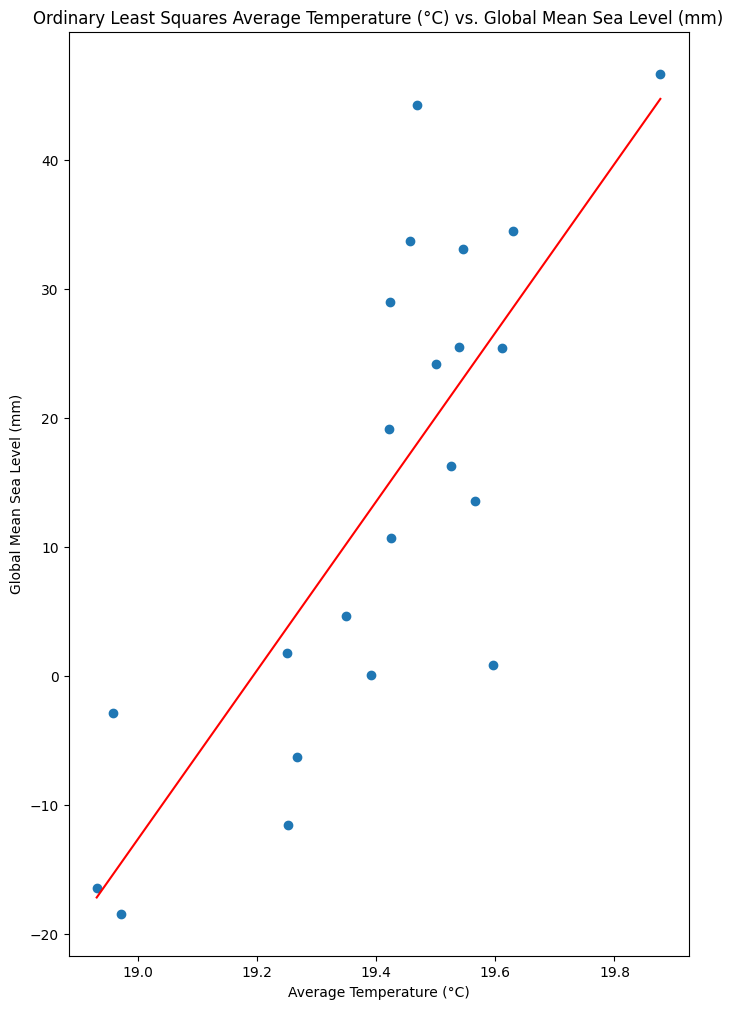

In [30]:
plt.figure(figsize = (8,12))
plt.scatter(combined['AverageTemperature: Celsius'], combined['gmsl_mm'])
temp = np.linspace(combined['AverageTemperature: Celsius'].min(), combined['AverageTemperature: Celsius'].max(), 100)
gmsl = ols.predict(sm.add_constant(temp))
plt.plot(temp, gmsl, color = 'red')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Global Mean Sea Level (mm)')
plt.title('Ordinary Least Squares Average Temperature (°C) vs. Global Mean Sea Level (mm)')
plt.show()

# Merge with AGGI data set

In [54]:
## column names check (1 point)

In [56]:
df = pd.read_csv("AGGI_Table.csv", header=2)
df.columns


Index(['Year', 'CO2', 'CH4', 'N2O', 'CFC*', 'HCFCs', 'HFCs*', 'Total',
       'Total.1', '1990 = 1', 'change **'],
      dtype='object')

In [57]:
## missing data check (1 point)

In [60]:
df.isnull().sum()

Year         1
CO2          4
CH4          4
N2O          4
CFC*         4
HCFCs        4
HFCs*        4
Total        4
Total.1      4
1990 = 1     4
change **    4
dtype: int64

In [62]:
#changing names for comprehension
df.rename(columns={
    'Total.1': 'CO2_eq_ppm', 
    '1990 = 1': 'AGGI', 
    'change **': 'AGGI_Change'
}, inplace=True)

df_cleaned = df.dropna(subset=['CO2']).copy()

print(df_cleaned.isnull().sum())

print("No more missing data")

Year           0
CO2            0
CH4            0
N2O            0
CFC*           0
HCFCs          0
HFCs*          0
Total          0
CO2_eq_ppm     0
AGGI           0
AGGI_Change    0
dtype: int64
No more missing data


In [64]:
## Outlier check (1 point)

In [66]:

any_outliers_found = False

columns_to_check = ['CO2', 'CH4', 'N2O', 'CFC*', 'HCFCs', 'HFCs*', 'Total', 'CO2_eq_ppm', 'AGGI']

for col in columns_to_check:

    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
        
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
        
    # identify any outliers
    outliers = df_cleaned[
        (df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)
    ]
        
    if (not(outliers.empty)):
        any_outliers_found = True
        print(outliers[['Year', col]])
    else:
        print(f"\nNo outliers found in '{col}'.")

print("\nOutliers found in CFC*")


No outliers found in 'CO2'.
   Year    CH4
0  1979  0.432

No outliers found in 'N2O'.
   Year   CFC*
0  1979  0.194
1  1980  0.204
2  1981  0.215
3  1982  0.226
4  1983  0.237

No outliers found in 'HCFCs'.

No outliers found in 'HFCs*'.

No outliers found in 'Total'.

No outliers found in 'CO2_eq_ppm'.

No outliers found in 'AGGI'.

Outliers found in CFC*


In [68]:
df_combined = combined #this is the dataset from merge earlier

df_combined.rename(columns={'year': 'Year'}, inplace=True)

df_cleaned['Year'] = df_cleaned['Year'].astype(int)

df_merged = pd.merge(df_cleaned, df_combined, on='Year', how='inner')

print(df_merged)

    Year    CO2    CH4    N2O   CFC*  HCFCs  HFCs*  Total  CO2_eq_ppm   AGGI  \
0   1992  1.364  0.495  0.137  0.343  0.022  0.003  2.365       433.0  1.028   
1   1993  1.375  0.495  0.138  0.346  0.024  0.004  2.382       434.0  1.035   
2   1994  1.399  0.497  0.140  0.348  0.025  0.004  2.413       437.0  1.049   
3   1995  1.427  0.500  0.141  0.349  0.027  0.005  2.449       440.0  1.064   
4   1996  1.455  0.501  0.144  0.350  0.028  0.005  2.483       443.0  1.079   
5   1997  1.472  0.502  0.146  0.350  0.030  0.006  2.506       445.0  1.089   
6   1998  1.512  0.506  0.149  0.350  0.031  0.007  2.556       449.0  1.111   
7   1999  1.545  0.509  0.152  0.350  0.033  0.008  2.596       452.0  1.128   
8   2000  1.563  0.509  0.156  0.349  0.035  0.008  2.620       454.0  1.139   
9   2001  1.587  0.509  0.158  0.348  0.036  0.010  2.647       456.0  1.151   
10  2002  1.617  0.509  0.160  0.347  0.038  0.011  2.682       459.0  1.166   
11  2003  1.656  0.511  0.163  0.345  0.

In [70]:
## data transformation, normalization, and cleaning (1 point)

In [72]:
df_merged['land_smooth'] = df_merged['land_smooth'].bfill()
df_merged['sea_level_smooth'] = df_merged['sea_level_smooth'].bfill()
print(df_merged)

    Year    CO2    CH4    N2O   CFC*  HCFCs  HFCs*  Total  CO2_eq_ppm   AGGI  \
0   1992  1.364  0.495  0.137  0.343  0.022  0.003  2.365       433.0  1.028   
1   1993  1.375  0.495  0.138  0.346  0.024  0.004  2.382       434.0  1.035   
2   1994  1.399  0.497  0.140  0.348  0.025  0.004  2.413       437.0  1.049   
3   1995  1.427  0.500  0.141  0.349  0.027  0.005  2.449       440.0  1.064   
4   1996  1.455  0.501  0.144  0.350  0.028  0.005  2.483       443.0  1.079   
5   1997  1.472  0.502  0.146  0.350  0.030  0.006  2.506       445.0  1.089   
6   1998  1.512  0.506  0.149  0.350  0.031  0.007  2.556       449.0  1.111   
7   1999  1.545  0.509  0.152  0.350  0.033  0.008  2.596       452.0  1.128   
8   2000  1.563  0.509  0.156  0.349  0.035  0.008  2.620       454.0  1.139   
9   2001  1.587  0.509  0.158  0.348  0.036  0.010  2.647       456.0  1.151   
10  2002  1.617  0.509  0.160  0.347  0.038  0.011  2.682       459.0  1.166   
11  2003  1.656  0.511  0.163  0.345  0.

In [74]:
df_merged

,Year,CO2,CH4,N2O,CFC*,HCFCs,HFCs*,Total,CO2_eq_ppm,AGGI,AGGI_Change,AverageTemperature: Celsius,gmsl_mm,land_smooth,sea_level_smooth
0,1992,1.364,0.495,0.137,0.343,0.022,0.003,2.365,433.0,1.028,1.2,18.972007,-18.465000,19.075991,-11.150180
1,1993,1.375,0.495,0.138,0.346,0.024,0.004,2.382,434.0,1.035,0.7,18.930800,-16.455441,19.075991,-11.150180
2,1994,1.399,0.497,0.140,0.348,0.025,0.004,2.413,437.0,1.049,1.4,19.251702,-11.599324,19.075991,-11.150180
3,1995,1.427,0.500,0.141,0.349,0.027,0.005,2.449,440.0,1.064,1.5,19.267070,-6.317871,19.075991,-11.150180
4,1996,1.455,0.501,0.144,0.350,0.028,0.005,2.483,443.0,1.079,1.5,18.958375,-2.913265,19.075991,-11.150180
5,1997,1.472,0.502,0.146,0.350,0.030,0.006,2.506,445.0,1.089,1.0,19.250351,1.799818,19.131659,-7.097216
6,1998,1.512,0.506,0.149,0.350,0.031,0.007,2.556,449.0,1.111,2.1,19.596783,0.859818,19.264856,-3.634165
7,1999,1.545,0.509,0.152,0.350,0.033,0.008,2.596,452.0,1.128,1.8,19.392100,0.045455,19.292936,-1.305209
8,2000,1.563,0.509,0.156,0.349,0.035,0.008,2.620,454.0,1.139,1.0,19.349202,4.642382,19.309362,0.886842
9,2001,1.587,0.509,0.158,0.348,0.036,0.010,2.647,456.0,1.151,1.2,19.425303,10.710306,19.402748,3.611556


In [170]:
from sklearn.preprocessing import MinMaxScaler

df_merged['Other_Gases'] = df_merged['CFC*'] + df['HCFCs'] + df['HFCs*']
columns_to_normalize = df_merged.columns.drop('Year')

new_col_names = [f"{col}_norm" for col in columns_to_normalize]

df_normalized_data = MinMaxScaler().fit_transform(df_merged[columns_to_normalize])
df_normalized = pd.DataFrame(df_normalized_data, columns=new_col_names, index=df_merged.index)

#The normalization helps with later visualizations.
#Data is cleaned.

df_processed = pd.concat([df_merged, df_normalized], axis=1)

print(df_processed.head(1))

   Year    CO2    CH4    N2O   CFC*  HCFCs  HFCs*  Total  CO2_eq_ppm   AGGI  \
0  1992  1.364  0.495  0.137  0.343  0.022  0.003  2.365       433.0  1.028   

   ...  HFCs*_norm  Total_norm  CO2_eq_ppm_norm  AGGI_norm  AGGI_Change_norm  \
0  ...         0.0         0.0              0.0        0.0          0.357143   

   AverageTemperature: Celsius_norm  gmsl_mm_norm  land_smooth_norm  \
0                           0.04355           0.0               0.0   

   sea_level_smooth_norm  Other_Gases_norm  
0                    0.0               0.0  

[1 rows x 31 columns]


In [172]:
## Exploratory data visualization (1 point)

Correlations for gases with Land Temperatures
           Gas  Correlation
2          N2O     0.940390
0          CO2     0.937576
4        HCFCs     0.930574
1          CH4     0.916316
5        HFCs*     0.880250
6  Other_Gases     0.791670
3         CFC*    -0.711386


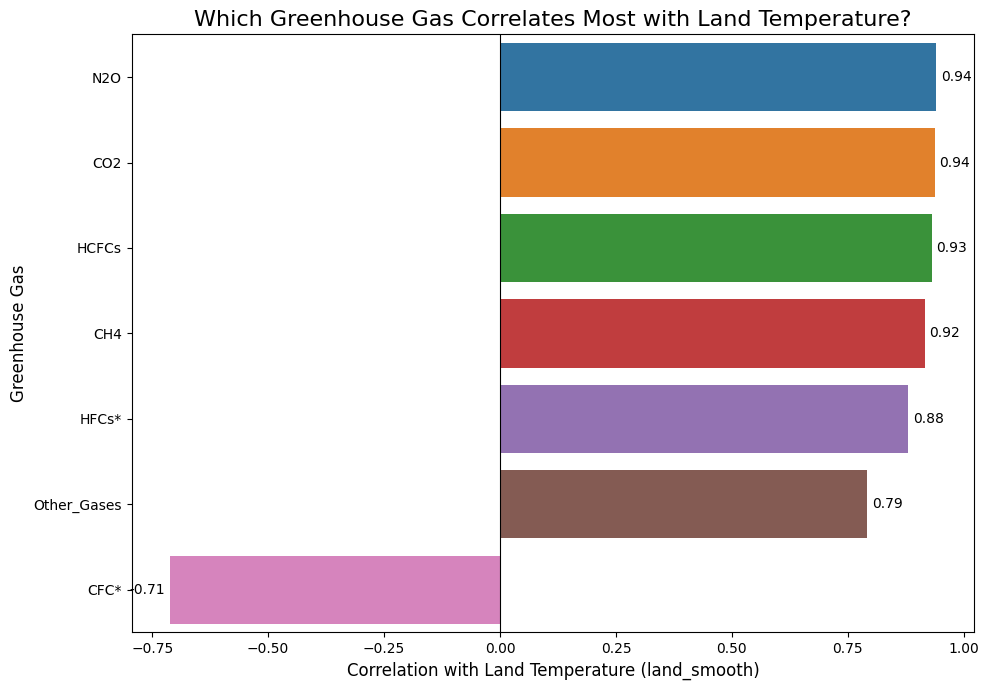

In [174]:
gas_columns = ['CO2', 'CH4', 'N2O', 'CFC*', 'HCFCs', 'HFCs*', 'Other_Gases']
temp_column = 'land_smooth'

correlations = df_merged[gas_columns].corrwith(df_merged[temp_column])

corr_df = correlations.reset_index()
corr_df.columns = ['Gas', 'Correlation']

corr_df = corr_df.sort_values(by='Correlation', ascending=False)
    
print("Correlations for gases with Land Temperatures")
print(corr_df)

plt.figure(figsize=(10, 7))
ax = sns.barplot(
    data=corr_df,
    x='Correlation',
    y='Gas',
    hue='Gas',
    orient='h'
)
    
ax.axvline(0, color='black', linewidth=0.8)
    
# Set titles and labels
ax.set_title('Which Greenhouse Gas Correlates Most with Land Temperature?', fontsize=16)
ax.set_xlabel('Correlation with Land Temperature (land_smooth)', fontsize=12)
ax.set_ylabel('Greenhouse Gas', fontsize=12)
    
for p in ax.patches:
    width = p.get_width()
    x_pos = width + 0.01 if width > 0 else width - 0.01
    ha = 'left' if width > 0 else 'right'
        
    ax.text(
        x_pos, 
        p.get_y() + p.get_height() / 2., 
        f'{width:.2f}',
        va='center',
        ha=ha
    )
plt.tight_layout()

--- Model Variables ---
Dependent variable (y): AverageTemperature: Celsius
Independent variable (X): AGGI (with constant)
   const   AGGI
0    1.0  1.028
1    1.0  1.035
2    1.0  1.049
3    1.0  1.064
4    1.0  1.079

--- OLS Regression Results ---
                                 OLS Regression Results                                
Dep. Variable:     AverageTemperature: Celsius   R-squared:                       0.614
Model:                                     OLS   Adj. R-squared:                  0.595
Method:                          Least Squares   F-statistic:                     31.82
Date:                         Sun, 09 Nov 2025   Prob (F-statistic):           1.61e-05
Time:                                 20:19:35   Log-Likelihood:                 11.927
No. Observations:                           22   AIC:                            -19.85
Df Residuals:                               20   BIC:                            -17.67
Df Model:                                    

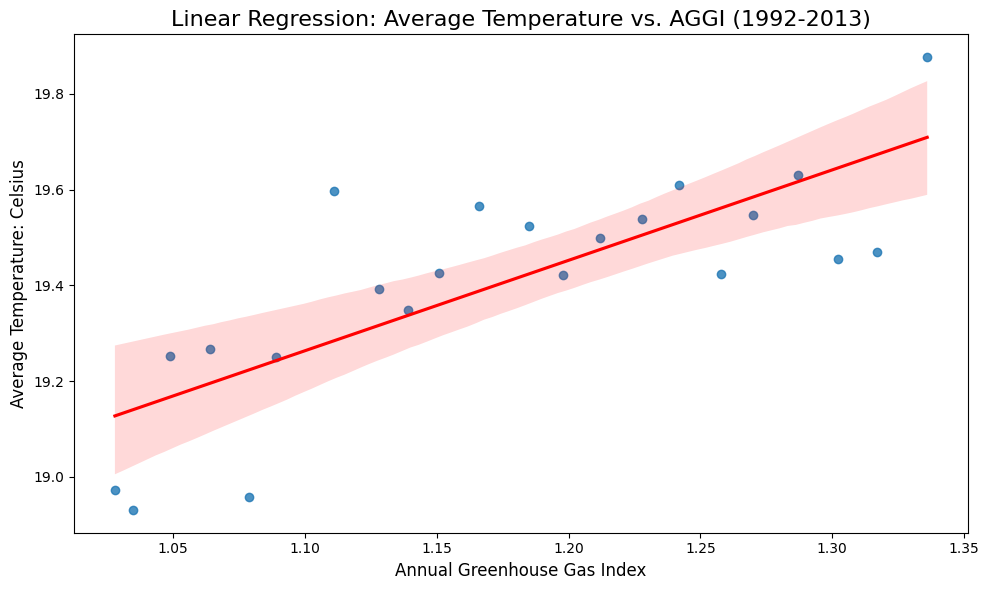

In [181]:
y = df_merged['AverageTemperature: Celsius']
x = df_merged['AGGI']
    
x = sm.add_constant(x)
    
print("--- Model Variables ---")
print("Dependent variable (y): AverageTemperature: Celsius")
print("Independent variable (X): AGGI (with constant)")
print(x.head())
model = sm.OLS(y, x).fit()

print("\n--- OLS Regression Results ---")
print(model.summary())
    

print("\n--- Generating Regression Plot ---")
    
plt.figure(figsize=(10, 6))
    
ax = sns.regplot(
    data=df_merged,
    x='AGGI',
    y='AverageTemperature: Celsius',
    line_kws={"color": "red"} # Make the regression line red
)
    
ax.set_title('Linear Regression: Average Temperature vs. AGGI (1992-2013)', fontsize=16)
ax.set_xlabel('Annual Greenhouse Gas Index', fontsize=12)
ax.set_ylabel('Average Temperature: Celsius', fontsize=12)
    
plt.tight_layout()

# Below code is to provide teamates with csv's

In [93]:
df_merged.to_csv("all_aggregated.csv") #Work with this!

#### Question: What correlation, if any, are present between Global Land Temperature and Eustatic Sea Level?

Correlations for gases with Land Temperatures
           Gas  Correlation
2          N2O     0.940390
0          CO2     0.937576
4        HCFCs     0.930574
1          CH4     0.916316
5        HFCs*     0.880250
6  Other_Gases     0.791670
3         CFC*    -0.711386


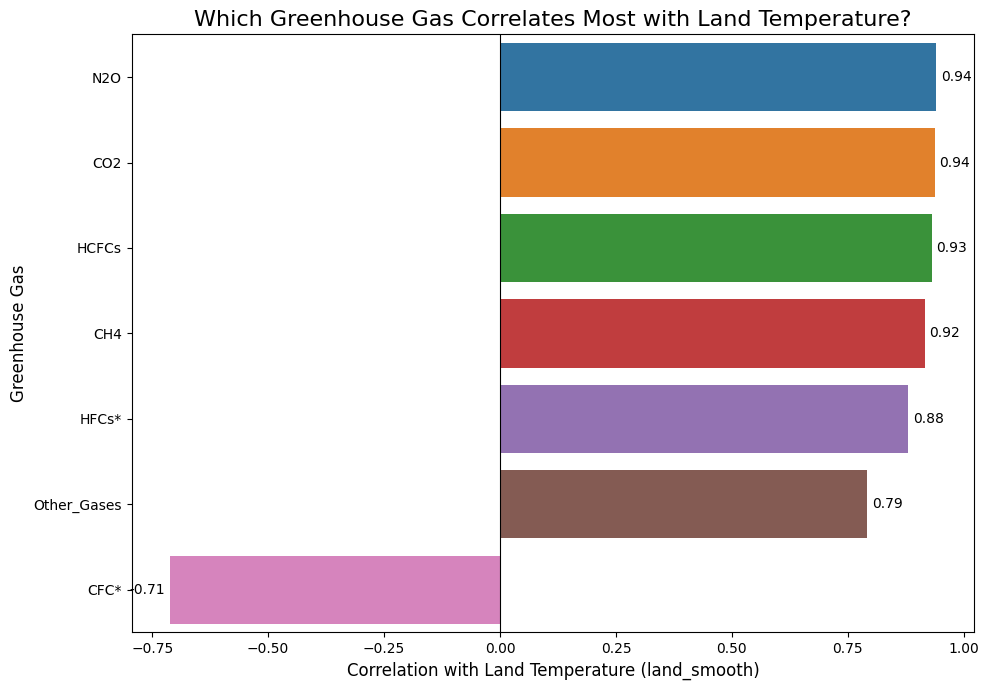

In [97]:
gas_columns = ['CO2', 'CH4', 'N2O', 'CFC*', 'HCFCs', 'HFCs*', 'Other_Gases']
temp_column = 'land_smooth'

correlations = df_merged[gas_columns].corrwith(df_merged[temp_column])

corr_df = correlations.reset_index()
corr_df.columns = ['Gas', 'Correlation']

corr_df = corr_df.sort_values(by='Correlation', ascending=False)
    
print("Correlations for gases with Land Temperatures")
print(corr_df)

plt.figure(figsize=(10, 7))
ax = sns.barplot(
    data=corr_df,
    x='Correlation',
    y='Gas',
    hue='Gas',
    orient='h'
)
    
ax.axvline(0, color='black', linewidth=0.8)
    
# Set titles and labels
ax.set_title('Which Greenhouse Gas Correlates Most with Land Temperature?', fontsize=16)
ax.set_xlabel('Correlation with Land Temperature (land_smooth)', fontsize=12)
ax.set_ylabel('Greenhouse Gas', fontsize=12)
    
for p in ax.patches:
    width = p.get_width()
    x_pos = width + 0.01 if width > 0 else width - 0.01
    ha = 'left' if width > 0 else 'right'
        
    ax.text(
        x_pos, 
        p.get_y() + p.get_height() / 2., 
        f'{width:.2f}',
        va='center',
        ha=ha
    )
plt.tight_layout()

--- Model Variables ---
Dependent variable (y): AverageTemperature: Celsius
Independent variable (X): AGGI (with constant)
   const   AGGI
0    1.0  1.028
1    1.0  1.035
2    1.0  1.049
3    1.0  1.064
4    1.0  1.079

--- OLS Regression Results ---
                                 OLS Regression Results                                
Dep. Variable:     AverageTemperature: Celsius   R-squared:                       0.614
Model:                                     OLS   Adj. R-squared:                  0.595
Method:                          Least Squares   F-statistic:                     31.82
Date:                         Sun, 09 Nov 2025   Prob (F-statistic):           1.61e-05
Time:                                 20:20:11   Log-Likelihood:                 11.927
No. Observations:                           22   AIC:                            -19.85
Df Residuals:                               20   BIC:                            -17.67
Df Model:                                    

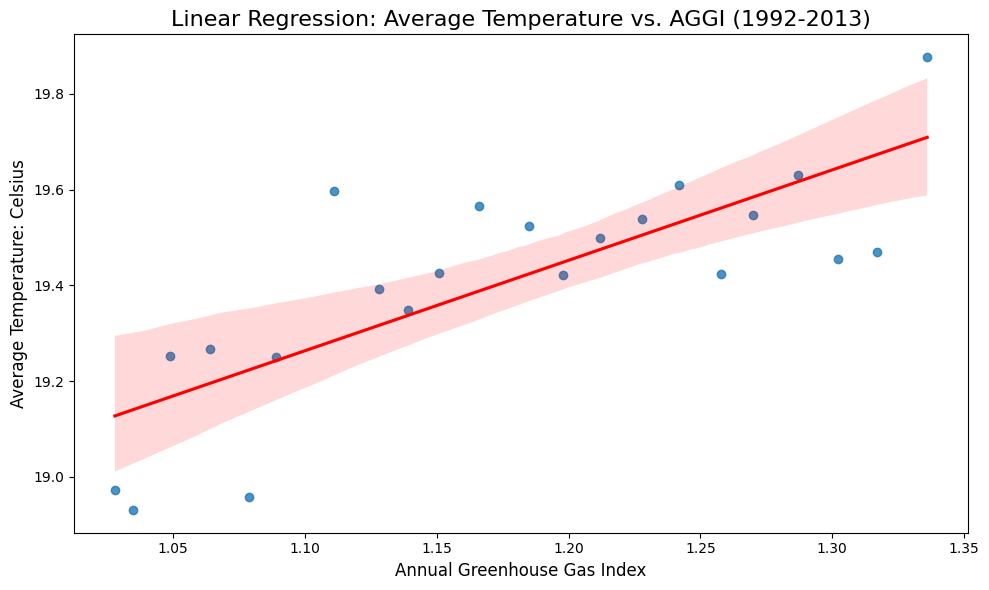

In [186]:
y = df_merged['AverageTemperature: Celsius']
x = df_merged['AGGI']
    
x = sm.add_constant(x)
    
print("--- Model Variables ---")
print("Dependent variable (y): AverageTemperature: Celsius")
print("Independent variable (X): AGGI (with constant)")
print(x.head())
model = sm.OLS(y, x).fit()

print("\n--- OLS Regression Results ---")
print(model.summary())
    

print("\n--- Generating Regression Plot ---")
    
plt.figure(figsize=(10, 6))
    
ax = sns.regplot(
    data=df_merged,
    x='AGGI',
    y='AverageTemperature: Celsius',
    line_kws={"color": "red"} # Make the regression line red
)
    
ax.set_title('Linear Regression: Average Temperature vs. AGGI (1992-2013)', fontsize=16)
ax.set_xlabel('Annual Greenhouse Gas Index', fontsize=12)
ax.set_ylabel('Average Temperature: Celsius', fontsize=12)
    
plt.tight_layout()

#### Answer:

There is indeed a significant positive correlation between Global Land Temperature and Eustatic (Global Mean) Sea Level. My linear regression plot at first glance obviously displays somewhat of a positive correlation between the two variables. However, my model summary provides necessary quantitative insight of an r-squared value of 0.626, a coefficient of 65.4930 for Average Land Temperature, and a p value of approximately zero. These statistics prove that for every 1 degree celsius increase, eustatic sea level rises by 65.4930 mm on average... and a p value of effectively zero proves that this finding is extremely statistically significant.

#### Question: Is there a significant time lag between temperature rise and sea level rise?

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Load the aggregated dataset
df = pd.read_csv("all_aggregated.csv")
print(df.columns)

Index(['Unnamed: 0', 'Year', 'CO2', 'CH4', 'N2O', 'CFC*', 'HCFCs', 'HFCs*',
       'Total', 'CO2_eq_ppm', 'AGGI', 'AGGI_Change',
       'AverageTemperature: Celsius', 'gmsl_mm', 'land_smooth',
       'sea_level_smooth', 'Other_Gases'],
      dtype='object')


In [295]:
# Test correlations at different time lags (0 to 5 years)

# Create list to store lag values and correlations
lags = range(0, 11)
lag_correlations = []

for lag in lags:
    if lag == 0:
        corr = df['land_smooth'].corr(df['sea_level_smooth'])
    else:
        # Slice and reset the index to make sure the indexes are aligned
        temp = df['land_smooth'][:-lag].reset_index(drop=True)
        sea = df['sea_level_smooth'][lag:].reset_index(drop=True)
        corr = temp.corr(sea)
    
    lag_correlations.append(corr)

# Create results table
lag_results = pd.DataFrame({
    'Lag (years)': list(lags),
    'Correlation': lag_correlations
})

print("Correlation between land temperature and sea level at different lags:")
print(lag_results)
print(f"\nOptimal lag: {lag_results['Correlation'].idxmax()} years")
print(f"Correlation at optimal lag: {lag_results['Correlation'].max()}")

Correlation between land temperature and sea level at different lags:
    Lag (years)  Correlation
0             0     0.928386
1             1     0.932855
2             2     0.951618
3             3     0.960648
4             4     0.960990
5             5     0.966064
6             6     0.973672
7             7     0.969897
8             8     0.955218
9             9     0.935085
10           10     0.921983

Optimal lag: 6 years
Correlation at optimal lag: 0.9736717221456141


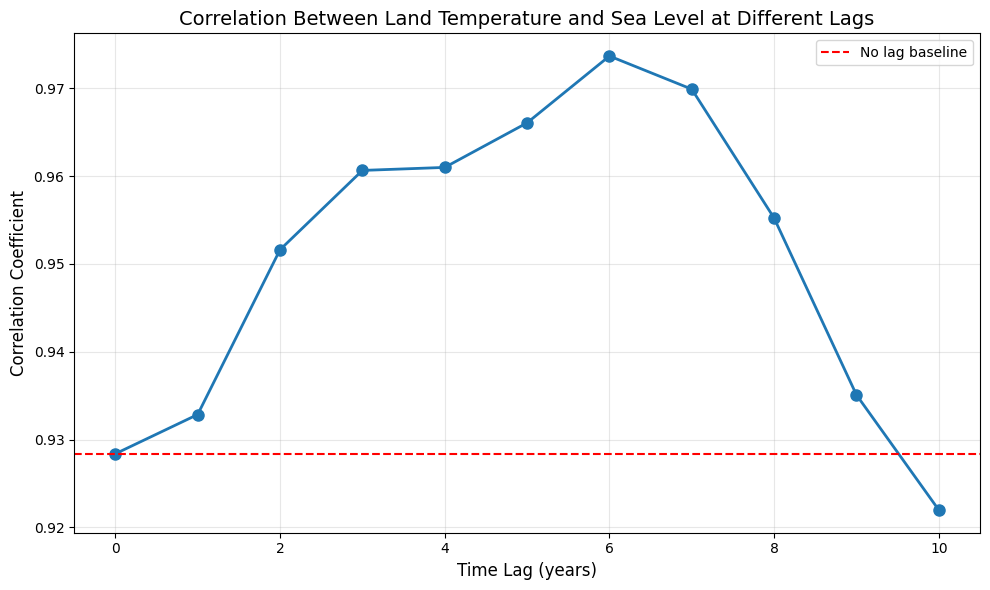

In [297]:
# Line plot showing how correlation changes with lag

plt.figure(figsize=(10,6))
plt.plot(lag_results['Lag (years)'], lag_results['Correlation'], 
         marker='o', linewidth=2, markersize=8)
plt.axhline(y=lag_results.loc[0, 'Correlation'], 
            color='red', linestyle='--', label='No lag baseline')
plt.xlabel('Time Lag (years)', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.title('Correlation Between Land Temperature and Sea Level at Different Lags', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

#### Observation for Visualization 1:

Initially, our analysis of a short time window suggested an optimal lag of 2 years. However, by expanding our search to a full decade, a more significant correlation appeared. The data clearly shows that the strongest correlation (r = 0.974) occurs when we compare sea levels to land temperatures from 6 years prior.

Our finding suggests that the sea level we observe today is a direct consequence of the global warming that occurred more than half a decade ago. 

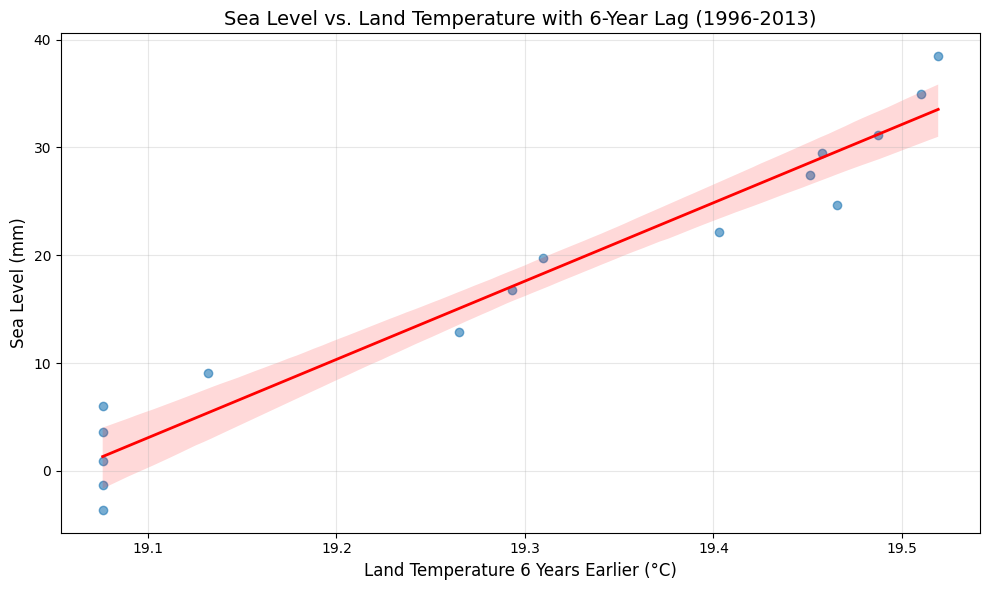

Correlation at optimal lag (6 years): 0.974


In [226]:
## Scatter plot comparing temperature (6 years earlier) to sea level

# Create lagged dataset
optimal_lag = 6
temp_leading = df['land_smooth'][:-optimal_lag].reset_index(drop=True)
sea_lagged = df['sea_level_smooth'][optimal_lag:].reset_index(drop=True)
year_lagged = df['Year'][optimal_lag:].reset_index(drop=True)

lagged_df = pd.DataFrame({
    'Temperature_6yr_earlier': temp_leading,
    'Sea_Level': sea_lagged,
    'Year': year_lagged
})

# Scatter plot with regression line
plt.figure(figsize=(10,6))
sns.regplot(data=lagged_df, x='Temperature_6yr_earlier', y='Sea_Level',
            scatter_kws={'alpha':0.6}, line_kws={'color':'red', 'linewidth':2})
plt.xlabel('Land Temperature 6 Years Earlier (°C)', fontsize=12)
plt.ylabel('Sea Level (mm)', fontsize=12)
plt.title('Sea Level vs. Land Temperature with 6-Year Lag (1996-2013)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Correlation at optimal lag (6 years): {temp_leading.corr(sea_lagged):.3f}")

#### Observation for Visualization 2:

When we align the data with the optimal 6-year lag, the relationship between past temperature and current sea level becomes clear and linear, as confirmed by the high correlation coefficient of 0.974. The tight clustering of the data points around the red regression line indicates that land temperature from six years prior is a very strong predictor of future sea level. The slope of the regression line show that for every 1°C increase in land temperature, the sea level rises substantially over the following six years.

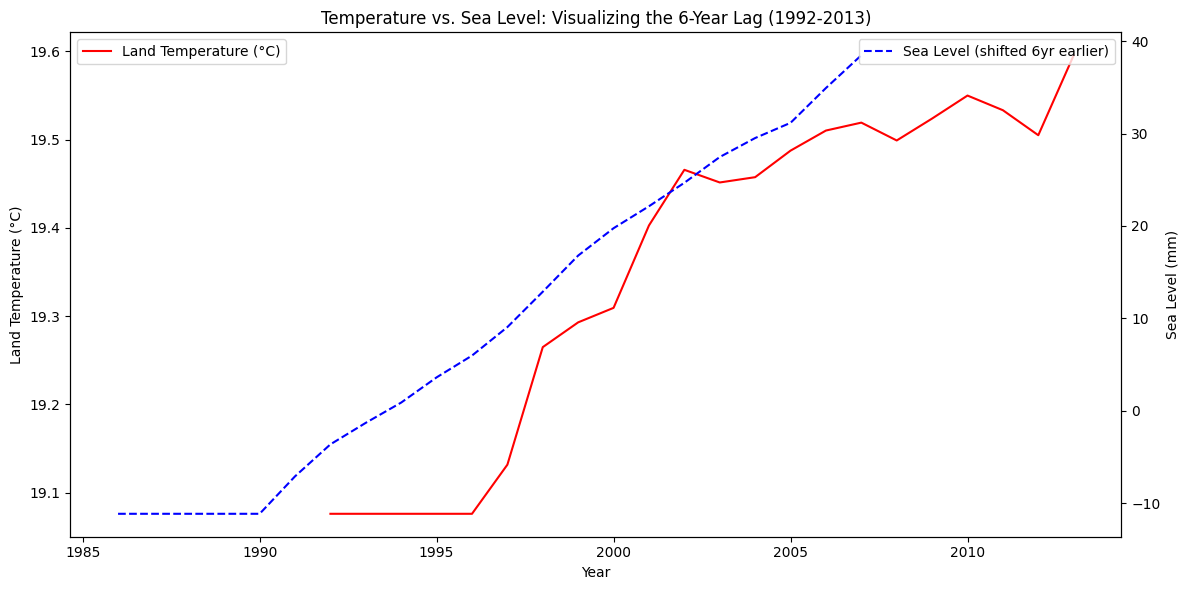

In [303]:
## Overlay temperature and sea level with lag adjustment

fig, ax1 = plt.subplots(figsize=(12,6))

# Plot temperature on left axis
ax1.plot(df['Year'], df['land_smooth'], color='red', label='Land Temperature (°C)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Land Temperature (°C)')
ax1.legend(loc='upper left')

# Plot sea level on right axis (shifted 6 years forward for visual comparison)
ax2 = ax1.twinx()
ax2.plot(df['Year'] - 6, df['sea_level_smooth'], color='blue',
         linestyle='--', label='Sea Level (shifted 6yr earlier)')
ax2.set_ylabel('Sea Level (mm)')
ax2.legend(loc='upper right')

plt.title('Temperature vs. Sea Level: Visualizing the 6-Year Lag (1992-2013)')
plt.tight_layout()
plt.show()

#### Observation for Visualization 3:

By visually shifting the sea level time series to align with temperature data from six years prior, we can illustrate the relationship discovered in our correlation analysis. The two curves now track each other, showing that the sea level trend in any given year closely follows the temperature pattern from six years before.

#### Answer

Yes, there is a significant time lag between temperature and sea level rise, with our analysis identifying an optimal delay of six years. The correlation between the two variables peaks at an extremely high r = 0.974 when accounting for this lag, a notable increase from the baseline correlation of r = 0.928. This six-year delay demonstrates that past temperature increases are a powerful predictor of future sea level rise, showing the long-term impact of warming on our oceans.

Correlation Results:
           Gas  Correlation
1          CH4     0.810555
0          CO2     0.777700
2          N2O     0.775995
4        HCFCs     0.773389
6  Other_Gases     0.769137
5        HFCs*     0.719602
3         CFC*    -0.535459


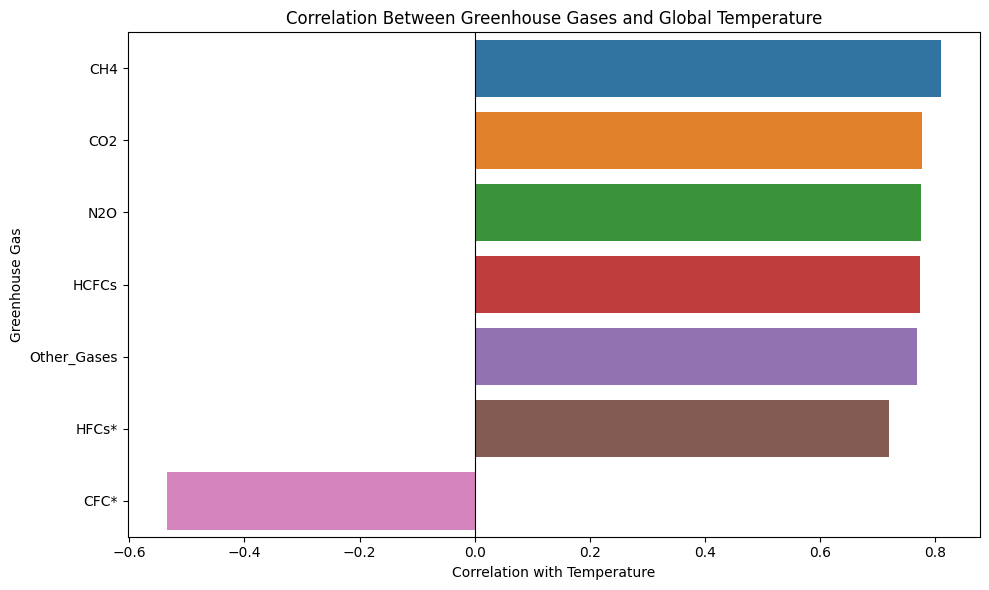

In [196]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load merged dataset
df = pd.read_csv("all_aggregated.csv")

# Select gases + temperature
gas_cols = ["CO2", "CH4", "N2O", "CFC*", "HCFCs", "HFCs*", "Other_Gases"]
temp_col = "AverageTemperature: Celsius"

# Compute correlations
corr_series = df[gas_cols].corrwith(df[temp_col])

# Format table
corr_df = corr_series.reset_index()
corr_df.columns = ["Gas", "Correlation"]
corr_df = corr_df.sort_values(by="Correlation", ascending=False)

print("Correlation Results:")
print(corr_df)

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=corr_df, x="Correlation", y="Gas", hue="Gas", dodge=False)
plt.title("Correlation Between Greenhouse Gases and Global Temperature")
plt.xlabel("Correlation with Temperature")
plt.ylabel("Greenhouse Gas")
plt.axvline(0, color="black", linewidth=0.8)
plt.tight_layout()
plt.show()

Correlations for gases with Land Temperatures
           Gas  Correlation
2          N2O     0.940390
0          CO2     0.937576
4        HCFCs     0.930574
1          CH4     0.916316
5        HFCs*     0.880250
6  Other_Gases     0.791670
3         CFC*    -0.711386


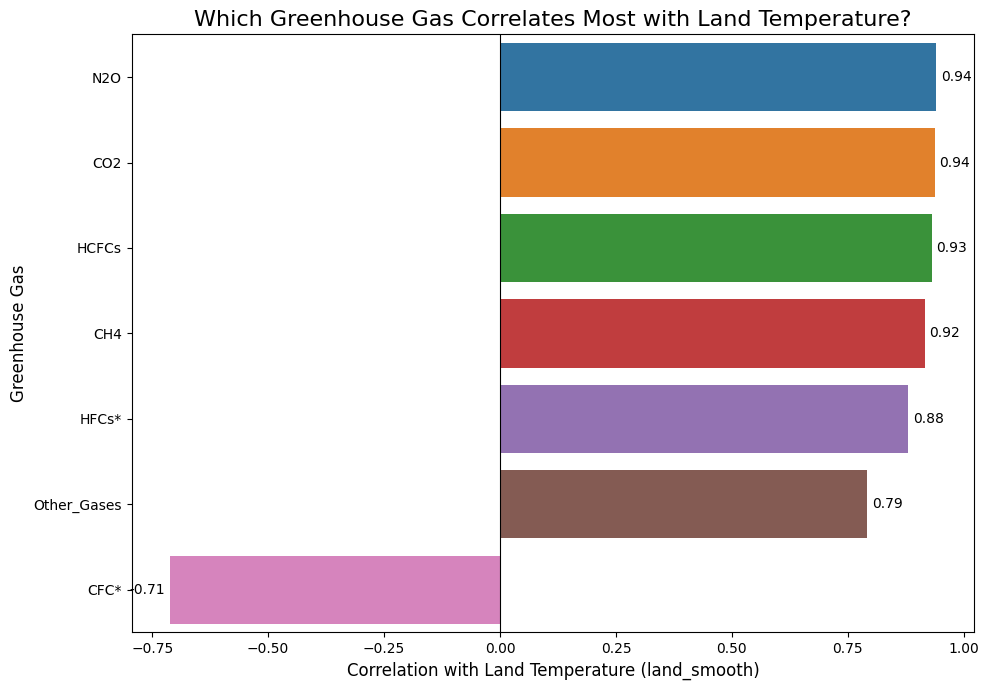

In [205]:
gas_columns = ['CO2', 'CH4', 'N2O', 'CFC*', 'HCFCs', 'HFCs*', 'Other_Gases']
temp_column = 'land_smooth'

correlations = df_merged[gas_columns].corrwith(df_merged[temp_column])

corr_df = correlations.reset_index()
corr_df.columns = ['Gas', 'Correlation']

corr_df = corr_df.sort_values(by='Correlation', ascending=False)
    
print("Correlations for gases with Land Temperatures")
print(corr_df)

plt.figure(figsize=(10, 7))
ax = sns.barplot(
    data=corr_df,
    x='Correlation',
    y='Gas',
    hue='Gas',
    orient='h'
)
    
ax.axvline(0, color='black', linewidth=0.8)
    
# Set titles and labels
ax.set_title('Which Greenhouse Gas Correlates Most with Land Temperature?', fontsize=16)
ax.set_xlabel('Correlation with Land Temperature (land_smooth)', fontsize=12)
ax.set_ylabel('Greenhouse Gas', fontsize=12)
    
for p in ax.patches:
    width = p.get_width()
    x_pos = width + 0.01 if width > 0 else width - 0.01
    ha = 'left' if width > 0 else 'right'
        
    ax.text(
        x_pos, 
        p.get_y() + p.get_height() / 2., 
        f'{width:.2f}',
        va='center',
        ha=ha
    )
plt.tight_layout()

## Key Findings

Our analysis revealed several important relationships:

1. **Temperature-Sea Level Correlation:** Strong positive relationship (R² = 0.626) - every 1°C increase in global land temperature corresponds to approximately 65.5mm sea level rise

2. **Greenhouse Gas Correlations:** Found correlations up to r ≈ 0.90 between the Annual Greenhouse Gas Index (AGGI) and global land temperatures

3. **Time-Lagged Effects:** Vector autoregression modeling showed that sea level responds to CO₂ emissions with a 1-2 year delay, while land temperatures are influenced by multiple gases with varying lag periods

For complete analysis and detailed results, see the full project report.